  <a href="https://colab.research.google.com/github/marcpalo1999/MIA_sanidad/blob/main/2_3_Visualizacion_y_Tests_Estadisticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if os.path.exists('/content'):
    if not os.path.exists('/content/MIA_sanidad'):
        os.system('git clone https://github.com/marcpalo1999/MIA_sanidad.git')
    os.chdir('/content/MIA_sanidad')
os.getcwd()

'/Volumes/Personal/CEMP/MIA_sanidad'

# Visualización de Datos y Tests Estadísticos en Medicina

En este notebook aprenderás:

- La lógica de Matplotlib y Seaborn: cómo "piensa" cada librería
- Los tipos de gráficos más útiles en análisis médico y cuándo usar cada uno
- Cómo interpretar lo que un gráfico te está diciendo clínicamente
- Tests estadísticos entre variables continuas: t-test, Mann-Whitney, ANOVA, correlación
- Tests estadísticos entre variables categóricas: chi-cuadrado, Fisher
- Cómo elegir el test correcto según el tipo de dato y la pregunta clínica

---
Trabajaremos con el mismo dataset de enfermedades cardíacas que ya conocéis.

In [2]:
# Importar todas las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librerías estadísticas
from scipy import stats
from scipy.stats import (ttest_ind, mannwhitneyu, f_oneway, kruskal,
                         chi2_contingency, fisher_exact, pearsonr, spearmanr,
                         shapiro, levene)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [3]:
# Cargar datos
df = pd.read_csv("./data/heart_disease_dataset_con_nulos.csv")

# Preprocesamiento mínimo necesario
df['target'] = (df['num'] > 0).astype(int)
df = df.dropna(subset=['num'])
df = df.drop(columns=['ca', 'num'])

# Etiquetas legibles para visualización
df['target_label'] = df['target'].map({0: 'Sin enfermedad', 1: 'Con enfermedad'})
df['sex_label'] = df['sex'].map({0: 'Mujer', 1: 'Hombre'})
df['cp_label'] = df['cp'].map({1: 'Angina típica', 2: 'Angina atípica',
                                3: 'No anginoso', 4: 'Asintomático'})

print(f"Dataset listo: {df.shape[0]} pacientes, {df.shape[1]} variables")
df.head()

Dataset listo: 287 pacientes, 16 variables


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,thal,target,target_label,sex_label,cp_label
0,63,1,1,145,233,1,2,150,0,2.3,3.0,6.0,0,Sin enfermedad,Hombre,Angina típica
1,67,1,4,160,286,0,2,108,1,1.5,2.0,3.0,1,Con enfermedad,Hombre,Asintomático
2,67,1,4,120,229,0,2,129,1,2.6,2.0,7.0,1,Con enfermedad,Hombre,Asintomático
3,37,1,3,130,250,0,0,187,0,3.5,3.0,3.0,0,Sin enfermedad,Hombre,No anginoso
4,41,0,2,130,204,0,2,172,0,1.4,1.0,3.0,0,Sin enfermedad,Mujer,Angina atípica


---
# PARTE 1: La Lógica de Matplotlib y Seaborn

Antes de memorizar comandos, hay que entender CÓMO piensan estas librerías.
Una vez que entiendes la arquitectura, puedes construir cualquier gráfico.

## 1.1 Matplotlib: la lógica de Figure y Axes

Matplotlib tiene una arquitectura en capas. La analogía más clara es la de un cuadro físico:

- **Figure** → el marco/lienzo. Es el "contenedor" total. Puedes tener varios gráficos dentro.
- **Axes** → el área de dibujo individual. Cada subplot es un Axes.
- **Artist** → todo lo que ves dibujado: líneas, barras, puntos, texto, ejes.

La confusión más frecuente al empezar: `plt.plot()` existe como atajo rápido,
pero en código serio siempre trabajaremos con la pareja `fig, ax = plt.subplots()`.
Esto te da control total.

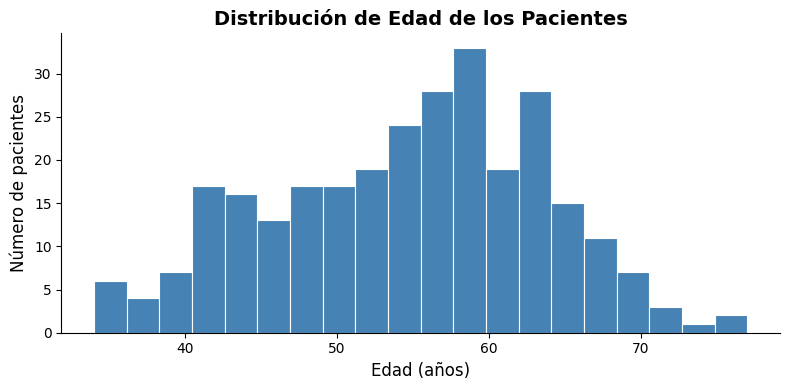

In [4]:
# --- Demostración de la arquitectura Figure / Axes ---

# FORMA RÁPIDA (para exploración en el notebook, no para código serio)
# plt.hist(df['age'])
# plt.show()

# FORMA CORRECTA Y RECOMENDADA
fig, ax = plt.subplots(figsize=(8, 4))      # Crear Figure y Axes
ax.hist(df['age'], bins=20, color='steelblue', edgecolor='white', linewidth=0.8)
ax.set_title('Distribución de Edad de los Pacientes', fontsize=14, fontweight='bold')
ax.set_xlabel('Edad (años)', fontsize=12)
ax.set_ylabel('Número de pacientes', fontsize=12)
ax.spines['top'].set_visible(False)         # Quitar bordes superiores (estética limpia)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### ¿Por qué `fig, ax = plt.subplots()` y no simplemente `plt.hist()`?

Con `fig, ax`:
- Controlas el tamaño exacto con `figsize`
- Puedes crear múltiples paneles fácilmente: `fig, axes = plt.subplots(1, 3)`
- Puedes acceder a cada subplot independientemente: `axes[0]`, `axes[1]`
- El código es reproducible y explícito (sabes exactamente en qué axes estás dibujando)
- Puedes guardarlo: `fig.savefig('mi_grafico.png', dpi=300, bbox_inches='tight')`

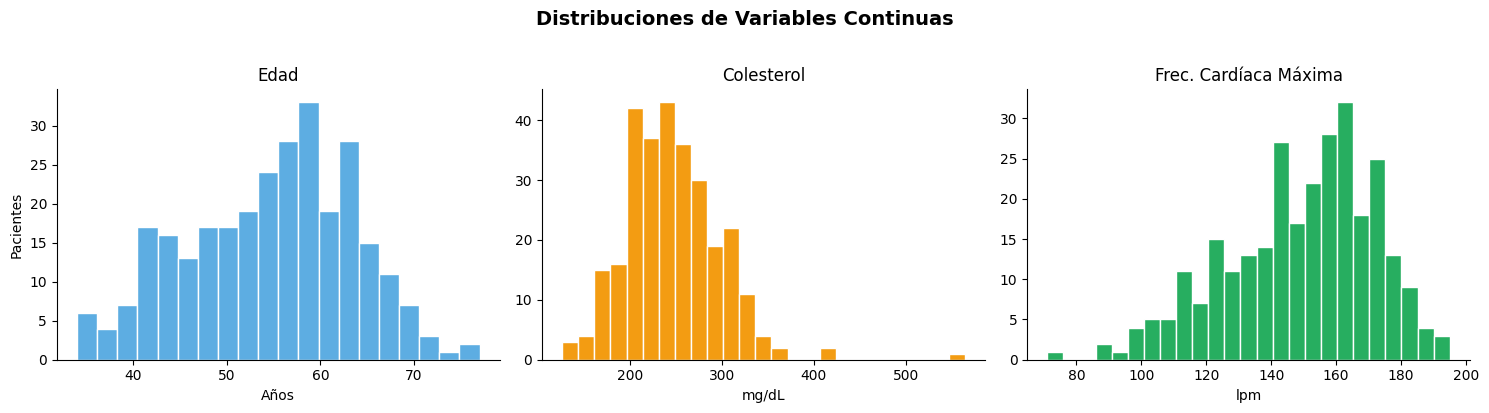

In [5]:
# --- Múltiples paneles: la potencia de subplots ---

fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 fila, 3 columnas

# Panel 0: histograma de edad
axes[0].hist(df['age'], bins=20, color='#5DADE2', edgecolor='white')
axes[0].set_title('Edad')
axes[0].set_xlabel('Años')
axes[0].set_ylabel('Pacientes')

# Panel 1: histograma de colesterol
axes[1].hist(df['chol'].dropna(), bins=25, color='#F39C12', edgecolor='white')
axes[1].set_title('Colesterol')
axes[1].set_xlabel('mg/dL')

# Panel 2: histograma de frecuencia cardíaca máxima
axes[2].hist(df['thalach'].dropna(), bins=25, color='#27AE60', edgecolor='white')
axes[2].set_title('Frec. Cardíaca Máxima')
axes[2].set_xlabel('lpm')

# Aplicar estética a todos a la vez con un bucle
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Distribuciones de Variables Continuas', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 1.2 Seaborn: la lógica de "estadística visual"

Seaborn está construido SOBRE Matplotlib. Aporta dos cosas fundamentales:

1. **Integración directa con DataFrames de pandas**: le pasas el DataFrame y los nombres de columna,
   Seaborn hace el resto.
2. **Gráficos estadísticos de alto nivel**: boxplots con grupos, violin plots, heatmaps de correlación,
   pairplots... todo con una sola línea.

La sintaxis de Seaborn siempre sigue este patrón:
```python
sns.tipo_de_grafico(data=mi_dataframe, x='columna_x', y='columna_y', hue='columna_grupo')
```
- `data`: el DataFrame
- `x`, `y`: las variables a representar
- `hue`: variable para colorear por grupos (muy útil en análisis clínico)
- `ax`: el axes de matplotlib donde dibujar (permite combinar los dos sistemas)

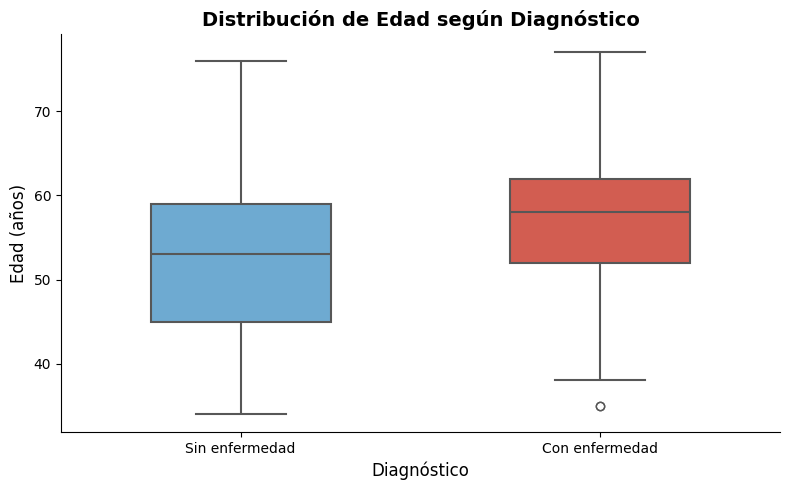

In [6]:
# --- Seaborn + Matplotlib juntos (el flujo correcto) ---

fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(data=df, x='target_label', y='age',
            palette=['#5DADE2', '#E74C3C'],
            width=0.5, linewidth=1.5, ax=ax)     # <-- pasamos el ax de matplotlib

ax.set_title('Distribución de Edad según Diagnóstico', fontsize=14, fontweight='bold')
ax.set_xlabel('Diagnóstico', fontsize=12)
ax.set_ylabel('Edad (años)', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Al pasar `ax=ax` a Seaborn, le estamos diciendo: "dibuja este gráfico dentro del axes que
yo ya he creado". Esto permite mezclar Seaborn y Matplotlib libremente, y es la forma
correcta de trabajar cuando necesitas layouts complejos con múltiples paneles.

---
# PARTE 2: Tipos de Gráficos y Cuándo Usar Cada Uno

## 2.1 Histograma — Distribución de una variable continua

**¿Para qué sirve?**
Ver cómo se distribuyen los valores de una variable continua.
En clínica: ¿los valores de colesterol de mis pacientes siguen una distribución normal?
¿hay outliers? ¿está sesgada hacia valores altos?

**Cuándo usarlo:** Exploración inicial de cualquier variable numérica. Siempre el primer paso.

**Lo que buscar:**
- Forma: ¿simétrica (normal), sesgada a la derecha/izquierda, bimodal?
- Outliers: barras aisladas muy a la derecha o izquierda
- Bimodalidad: dos "jorobas" pueden indicar que hay dos subpoblaciones mezcladas

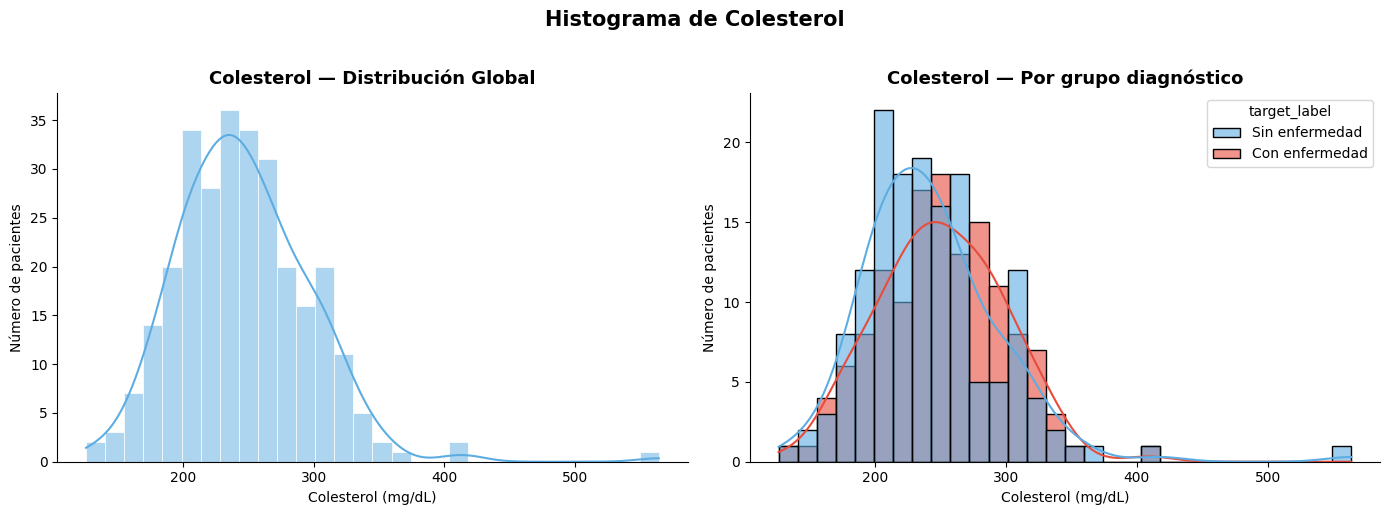

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma simple con curva de densidad (KDE)
sns.histplot(data=df, x='chol', bins=30, kde=True, color='#5DADE2',
             edgecolor='white', linewidth=0.5, ax=axes[0])
axes[0].set_title('Colesterol — Distribución Global', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Colesterol (mg/dL)')
axes[0].set_ylabel('Número de pacientes')

# Histograma por grupos (hue): ver si hay diferencias entre grupos
sns.histplot(data=df, x='chol', bins=30, kde=True, hue='target_label',
             palette=['#5DADE2', '#E74C3C'], alpha=0.6, ax=axes[1])
axes[1].set_title('Colesterol — Por grupo diagnóstico', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Colesterol (mg/dL)')
axes[1].set_ylabel('Número de pacientes')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Histograma de Colesterol', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Interpretación clínica:** La curva KDE (Kernel Density Estimate) es la línea suave superpuesta.
Es una versión "suavizada" del histograma, útil para comparar formas entre grupos sin depender
del número de bins elegido. Cuando la KDE de dos grupos se solapa mucho, la variable
discrimina poco entre ellos.

## 2.2 Boxplot (Diagrama de Caja) — Comparar distribuciones entre grupos

**¿Para qué sirve?**
Resumir la distribución de una variable continua y comparar entre grupos simultáneamente.
En clínica: ¿es diferente la frecuencia cardíaca máxima entre pacientes con y sin enfermedad?

**Anatomía del boxplot:**
- Línea central: **mediana** (percentil 50)
- Caja: de Q1 (P25) a Q3 (P75) → el **rango intercuartílico (IQR)**
- Bigotes: hasta 1.5×IQR desde la caja
- Puntos aislados: **outliers** (valores más allá de los bigotes)

**Cuándo usarlo:** Comparar una variable continua entre 2 o más grupos categóricos.

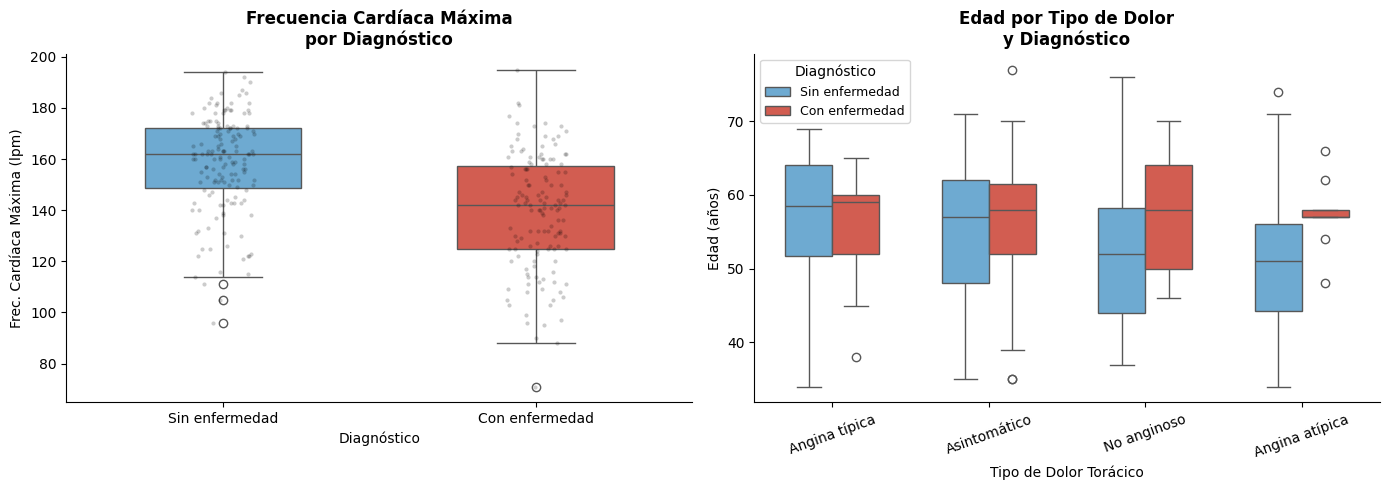

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot simple por grupos
sns.boxplot(data=df, x='target_label', y='thalach',
            palette=['#5DADE2', '#E74C3C'], width=0.5, ax=axes[0])
# Superponer los puntos individuales para ver la distribución real
sns.stripplot(data=df, x='target_label', y='thalach',
              color='black', alpha=0.2, size=3, jitter=True, ax=axes[0])
axes[0].set_title('Frecuencia Cardíaca Máxima\npor Diagnóstico', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Diagnóstico')
axes[0].set_ylabel('Frec. Cardíaca Máxima (lpm)')

# Boxplot con múltiples grupos (x=categoria, hue=segundo grupo)
sns.boxplot(data=df, x='cp_label', y='age',
            hue='target_label', palette=['#5DADE2', '#E74C3C'],
            width=0.6, ax=axes[1])
axes[1].set_title('Edad por Tipo de Dolor\ny Diagnóstico', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tipo de Dolor Torácico')
axes[1].set_ylabel('Edad (años)')
axes[1].tick_params(axis='x', rotation=20)
axes[1].legend(title='Diagnóstico', fontsize=9)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**Nota clínica:** Fijáos en el panel izquierdo cómo los pacientes CON enfermedad coronaria
tienen una frecuencia cardíaca máxima claramente inferior a los pacientes sanos.
Esto tiene sentido fisiológico: la isquemia limita la respuesta cardíaca al ejercicio.
Este es el tipo de hallazgo que justifica un test estadístico formal (lo haremos en la Parte 3).

## 2.3 Violin Plot — Distribución completa + comparación entre grupos

**¿Para qué sirve?**
Lo mismo que el boxplot, pero muestra la forma completa de la distribución (no solo percentiles).
Es especialmente útil cuando la distribución NO es simétrica o tiene múltiples modas.

**Cuándo usarlo:** Cuando sospechas que la distribución tiene forma particular (bimodal,
muy asimétrica) y quieres que el gráfico lo muestre claramente. Con pocos datos (<30)
el violín puede ser engañoso — en ese caso, preferir boxplot con stripplot.

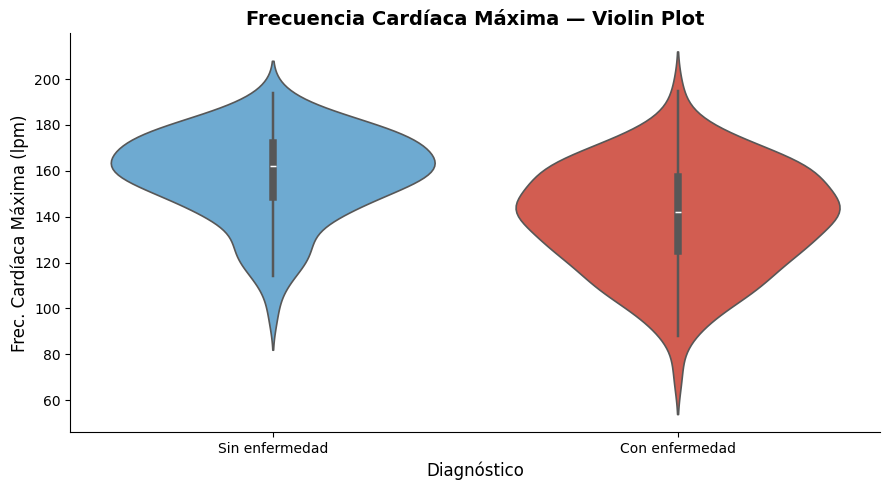

In [10]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.violinplot(data=df, x='target_label', y='thalach',
               palette=['#5DADE2', '#E74C3C'],
               inner='box',           # Muestra el boxplot dentro del violín
               linewidth=1.2, ax=ax)

ax.set_title('Frecuencia Cardíaca Máxima — Violin Plot',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Diagnóstico', fontsize=12)
ax.set_ylabel('Frec. Cardíaca Máxima (lpm)', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**Boxplot vs Violin:** El boxplot te dice dónde están los percentiles. El violín te dice
además si hay zonas donde los valores se "acumulan" (parte ancha del violín) o son
escasos (parte estrecha). Para comunicar resultados a una audiencia clínica,
el boxplot suele ser más intuitivo. Para exploración analítica, el violín aporta más información.

## 2.4 Scatter Plot (Diagrama de Dispersión) — Relación entre dos variables continuas

**¿Para qué sirve?**
Ver si existe relación (correlación) entre dos variables numéricas.
En clínica: ¿aumenta la presión arterial con la edad? ¿se relacionan colesterol y frecuencia cardíaca?

**Lo que buscar:**
- Tendencia ascendente: correlación positiva
- Tendencia descendente: correlación negativa
- Nube sin forma: sin correlación
- Forma no lineal (curva): correlación no lineal (Pearson no la capturaría bien)
- Clusters separados: posibles subpoblaciones

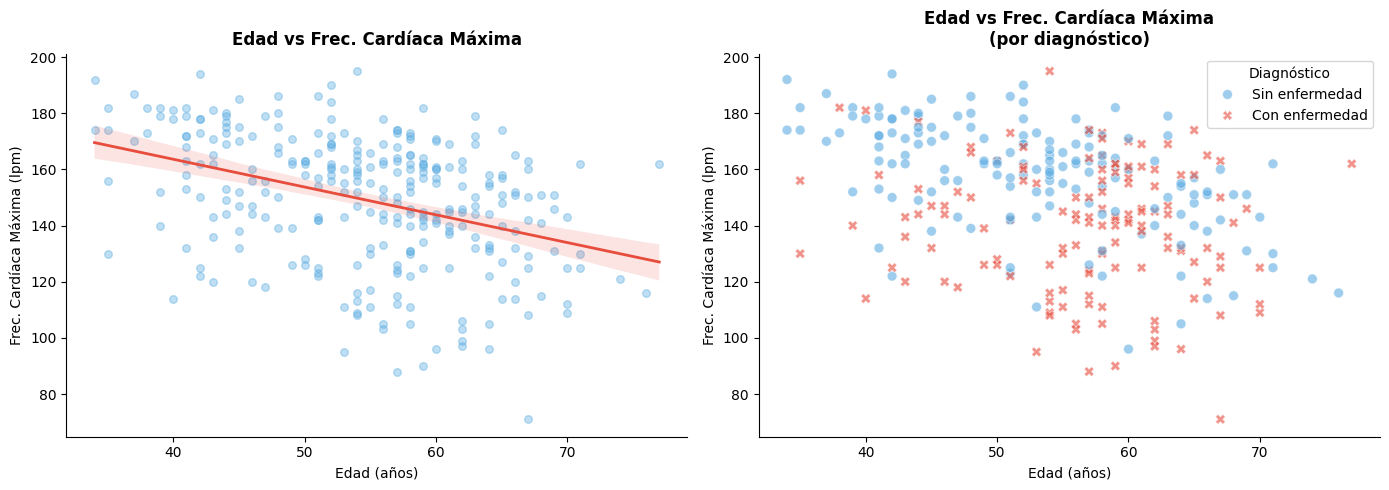

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter básico con línea de tendencia
sns.regplot(data=df, x='age', y='thalach',
            scatter_kws={'alpha': 0.4, 'color': '#5DADE2', 's': 30},
            line_kws={'color': '#E74C3C', 'linewidth': 2},
            ax=axes[0])
axes[0].set_title('Edad vs Frec. Cardíaca Máxima', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Frec. Cardíaca Máxima (lpm)')

# Scatter coloreado por grupo diagnóstico
sns.scatterplot(data=df, x='age', y='thalach',
                hue='target_label', style='target_label',
                palette=['#5DADE2', '#E74C3C'],
                alpha=0.6, s=50, ax=axes[1])
axes[1].set_title('Edad vs Frec. Cardíaca Máxima\n(por diagnóstico)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Edad (años)')
axes[1].set_ylabel('Frec. Cardíaca Máxima (lpm)')
axes[1].legend(title='Diagnóstico')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**Interpretación:** La línea de tendencia (regplot) muestra claramente una correlación negativa
entre edad y frecuencia cardíaca máxima: a mayor edad, menor capacidad de respuesta cronotrópica.
Esto es fisiología conocida. El color por grupos (panel derecho) revela además que los pacientes
con enfermedad (rojo) se acumulan en la zona de edad alta y frecuencia cardíaca baja.

## 2.5 Bar Plot — Frecuencias y proporciones de variables categóricas

**¿Para qué sirve?**
Representar la frecuencia o proporción de categorías. En clínica: distribución del sexo,
tipos de dolor torácico, prevalencia de enfermedad por subgrupos.

**Cuándo usarlo:** Cuando una o ambas variables son categóricas.
Para comparar proporciones entre grupos, el gráfico de barras apiladas al 100% es especialmente útil.

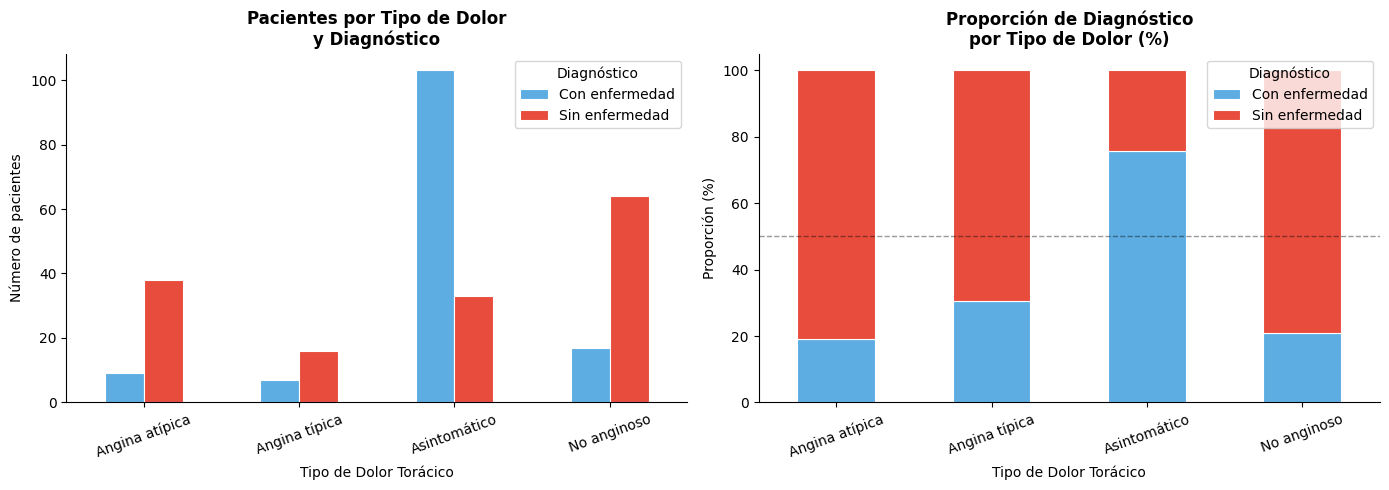

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot de frecuencia por tipo de dolor, coloreado por diagnóstico
ct = df.groupby(['cp_label', 'target_label']).size().reset_index(name='count')
ct_pivot = ct.pivot(index='cp_label', columns='target_label', values='count').fillna(0)

ct_pivot.plot(kind='bar', ax=axes[0], color=['#5DADE2', '#E74C3C'],
              edgecolor='white', linewidth=0.8, rot=20)
axes[0].set_title('Pacientes por Tipo de Dolor\ny Diagnóstico', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Tipo de Dolor Torácico')
axes[0].set_ylabel('Número de pacientes')
axes[0].legend(title='Diagnóstico')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Barras apiladas al 100% — muestra PROPORCIÓN dentro de cada grupo
ct_pivot_pct = ct_pivot.div(ct_pivot.sum(axis=1), axis=0) * 100
ct_pivot_pct.plot(kind='bar', stacked=True, ax=axes[1],
                  color=['#5DADE2', '#E74C3C'], edgecolor='white', linewidth=0.8, rot=20)
axes[1].set_title('Proporción de Diagnóstico\npor Tipo de Dolor (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tipo de Dolor Torácico')
axes[1].set_ylabel('Proporción (%)')
axes[1].axhline(50, color='black', linestyle='--', linewidth=1, alpha=0.4)
axes[1].legend(title='Diagnóstico', loc='upper right')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 2.6 Heatmap de Correlación — Visión global de relaciones entre variables continuas

**¿Para qué sirve?**
Ver de un vistazo las correlaciones entre todas las variables numéricas.
En clínica: detectar qué variables van "juntas" y qué variables son redundantes.

**Lo que buscar:**
- Rojo intenso (correlación alta positiva): las variables aumentan juntas
- Azul intenso (correlación alta negativa): cuando una sube, la otra baja
- Colores neutros (cerca de 0): no hay relación lineal
- La diagonal siempre es 1 (cada variable se correlaciona perfectamente consigo misma)

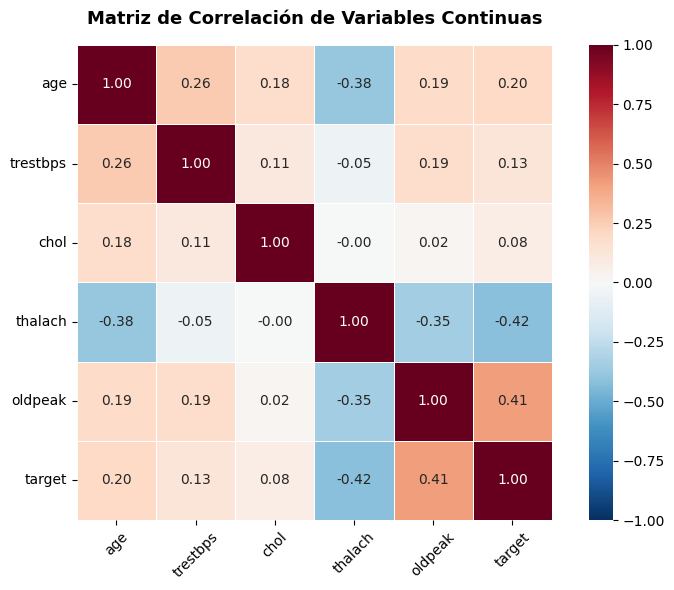

In [13]:
# Seleccionar variables continuas relevantes
vars_continuas = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']

corr_matrix = df[vars_continuas].corr()

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(corr_matrix,
            annot=True,               # Mostrar valores numéricos
            fmt='.2f',                # 2 decimales
            cmap='RdBu_r',            # Rojo=positivo, Azul=negativo
            vmin=-1, vmax=1,          # Escala fija de -1 a 1
            center=0,
            square=True,              # Celdas cuadradas
            linewidths=0.5,
            linecolor='white',
            ax=ax)

ax.set_title('Matriz de Correlación de Variables Continuas',
             fontsize=13, fontweight='bold', pad=15)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

**Interpretación:** Fijáos en la columna `target` (última fila/columna):
- `thalach` (frec. cardíaca máxima) tiene correlación negativa con `target`: a mayor capacidad
  cronotrópica, menor probabilidad de enfermedad.
- `oldpeak` (depresión del ST en esfuerzo) tiene correlación positiva con `target`: más depresión
  del ST indica más isquemia.

Este tipo de análisis guía la selección de variables para el modelo de ML.

## 2.7 Pairplot — Exploración exhaustiva de todas las relaciones

**¿Para qué sirve?**
Generar automáticamente scatter plots entre todos los pares de variables + histogramas en la diagonal.
Útil para exploración inicial cuando no sabes qué relaciones buscar.

**Cuándo usarlo:** Exploración. Con más de 6-7 variables empieza a ser difícil de leer.

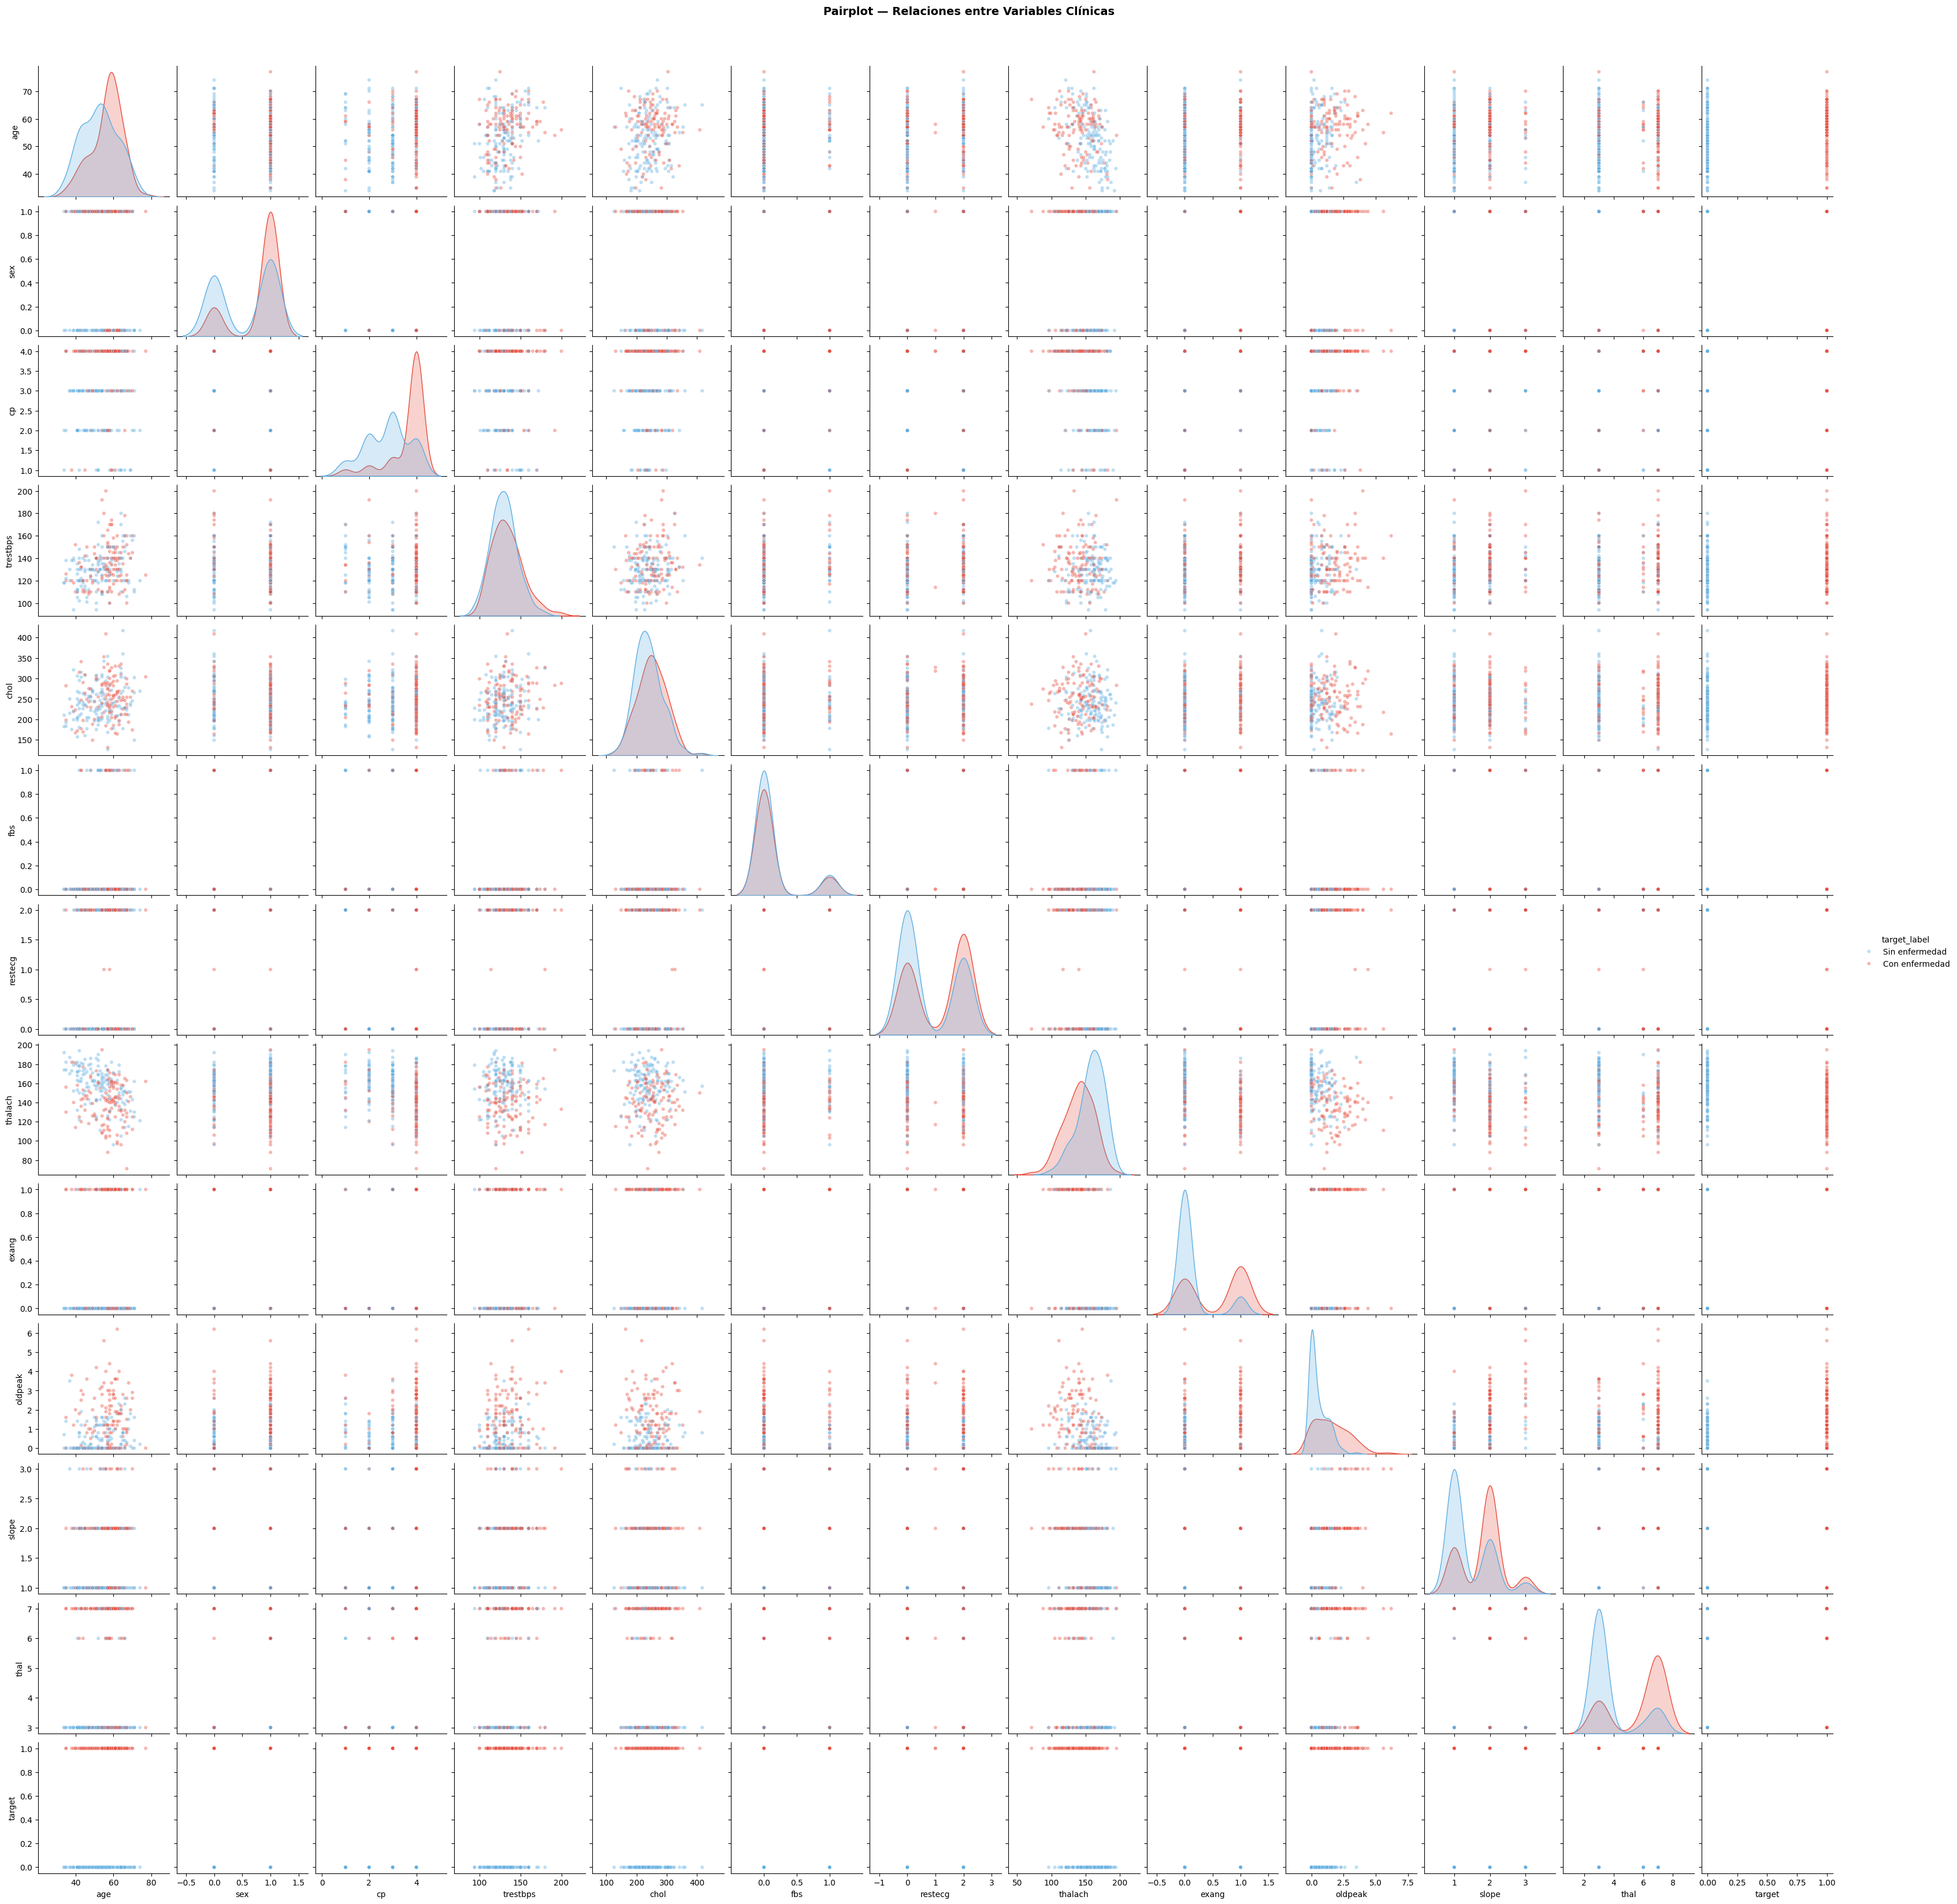

In [15]:
vars_pairplot = ['age', 'thalach', 'oldpeak', 'trestbps', 'target_label']
df_pair = df.dropna()

g = sns.pairplot(df_pair, hue='target_label',
                 palette=['#5DADE2', '#E74C3C'],
                 plot_kws={'alpha': 0.4, 's': 20},
                 diag_kind='kde')

g.fig.suptitle('Pairplot — Relaciones entre Variables Clínicas', y=1.02,
               fontsize=14, fontweight='bold')
plt.show()

**Tip:** El pairplot es la herramienta de exploración más rápida antes de entrenar cualquier modelo.
Si ya en el pairplot ves separación visual clara entre grupos (rojo vs azul), el modelo de ML
probablemente funcionará bien. Si los colores están completamente mezclados, la tarea es difícil.

---
# PARTE 3: Tests Estadísticos entre Variables Continuas

Los gráficos nos permiten ver diferencias visualmente. Los tests estadísticos nos dicen
si esas diferencias son **estadísticamente significativas** (es decir, improbables bajo la
hipótesis de que no existe diferencia real en la población).

**El flujo correcto siempre es:**
1. Visualizar (boxplot, histograma)
2. Comprobar supuestos del test (normalidad, homogeneidad de varianzas)
3. Elegir el test apropiado según los supuestos
4. Ejecutar el test e interpretar p-valor Y tamaño del efecto
5. Formular la conclusión clínica

## 3.1 El p-valor: qué es y qué NO es

**Definición correcta:** El p-valor es la probabilidad de observar una diferencia tan extrema
como la que hemos medido (o más extrema), **asumiendo que la hipótesis nula es verdadera**.

La hipótesis nula (H₀) en comparaciones de grupos es siempre: "no hay diferencia entre los grupos".

- **p < 0.05**: si la hipótesis nula fuera cierta, solo habría un 5% de probabilidad de ver
  una diferencia tan grande. Convencionalmente, rechazamos H₀ y decimos que la diferencia
  es "estadísticamente significativa".
- **p > 0.05**: no tenemos evidencia suficiente para rechazar H₀.

**Lo que el p-valor NO es:**
- NO es la probabilidad de que H₀ sea verdadera
- NO dice nada sobre la importancia clínica de la diferencia
- Un p muy pequeño con n grande puede ser trivial clínicamente

Por eso siempre hay que reportar también el **tamaño del efecto** (Cohen's d, etc.)

## 3.2 Comprobar Normalidad — Test de Shapiro-Wilk

Antes de elegir entre un test paramétrico (t-test) o no paramétrico (Mann-Whitney),
debemos verificar si los datos siguen distribución normal.

**Shapiro-Wilk:**
- H₀: los datos siguen una distribución normal
- Si p > 0.05: no hay evidencia de no-normalidad → podemos asumir normalidad
- Si p < 0.05: los datos se desvían significativamente de la normal → usar test no paramétrico

**Limitación importante:** Con muestras grandes (n > 50-100), Shapiro-Wilk casi siempre
rechaza H₀ aunque la distribución sea "suficientemente normal" para los tests paramétricos.
En esos casos, el criterio visual (QQ-plot + histograma) pesa más que el p-valor del Shapiro.

Shapiro-Wilk — Sin enfermedad:
  n=151, W=0.9586, p=0.0002
  ✗ Desviación significativa de normalidad (p<0.05)

Shapiro-Wilk — Con enfermedad:
  n=136, W=0.9891, p=0.3675
  ✓ Normalidad asumida (p>0.05)



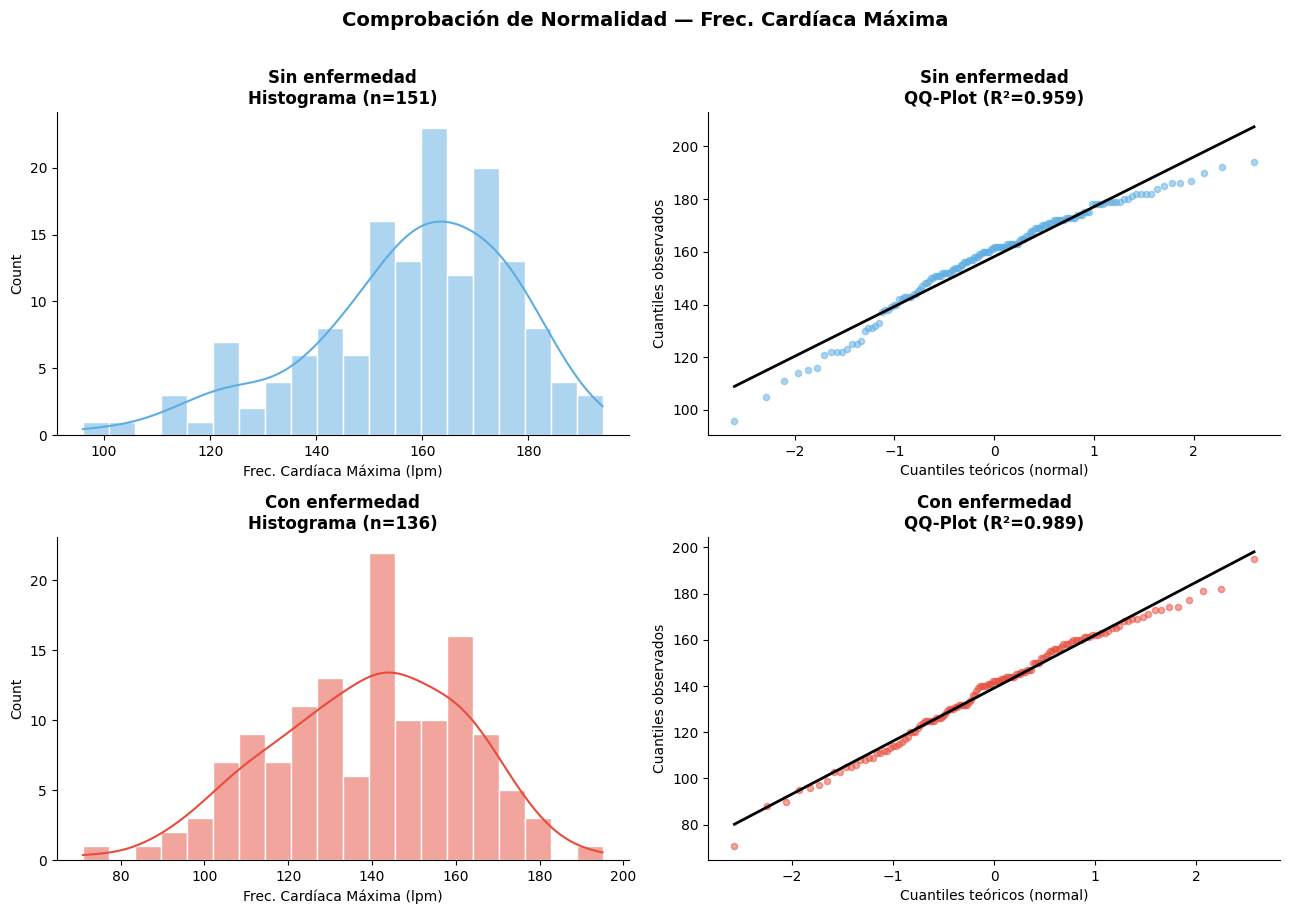

In [16]:
# Comprobar normalidad de thalach (frec. cardíaca máxima) por grupos

grupos = {
    'Sin enfermedad': df[df['target'] == 0]['thalach'].dropna(),
    'Con enfermedad': df[df['target'] == 1]['thalach'].dropna()
}

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

for i, (nombre, datos) in enumerate(grupos.items()):
    # Histograma + KDE
    sns.histplot(datos, kde=True, bins=20,
                 color='#5DADE2' if i == 0 else '#E74C3C',
                 edgecolor='white', ax=axes[i, 0])
    axes[i, 0].set_title(f'{nombre}\nHistograma (n={len(datos)})', fontweight='bold')
    axes[i, 0].set_xlabel('Frec. Cardíaca Máxima (lpm)')
    axes[i, 0].spines['top'].set_visible(False)
    axes[i, 0].spines['right'].set_visible(False)

    # QQ-plot
    (osm, osr), (slope, intercept, r) = stats.probplot(datos)
    axes[i, 1].scatter(osm, osr, alpha=0.5, s=20,
                       color='#5DADE2' if i == 0 else '#E74C3C')
    linea_x = np.array([min(osm), max(osm)])
    axes[i, 1].plot(linea_x, slope * linea_x + intercept, 'k-', linewidth=2)
    axes[i, 1].set_title(f'{nombre}\nQQ-Plot (R²={r**2:.3f})', fontweight='bold')
    axes[i, 1].set_xlabel('Cuantiles teóricos (normal)')
    axes[i, 1].set_ylabel('Cuantiles observados')
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)

    # Test de Shapiro-Wilk
    stat, p = shapiro(datos)
    print(f"Shapiro-Wilk — {nombre}:")
    print(f"  n={len(datos)}, W={stat:.4f}, p={p:.4f}")
    print(f"  {'✓ Normalidad asumida (p>0.05)' if p > 0.05 else '✗ Desviación significativa de normalidad (p<0.05)'}\n")

plt.suptitle('Comprobación de Normalidad — Frec. Cardíaca Máxima',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

**Interpretación del QQ-plot:** Si los puntos siguen la línea diagonal, la distribución es normal.
Desviaciones en las colas (puntos curvándose arriba o abajo en los extremos) indican colas
más pesadas que la normal. Si la mayoría de los puntos están sobre la diagonal y R² > 0.98,
la normalidad es razonable.

## 3.3 Test t de Student — Comparar medias entre dos grupos independientes

**Cuando usarlo:** Variable continua, dos grupos independientes, distribución aproximadamente normal.

**H₀:** Las medias de los dos grupos son iguales (μ₁ = μ₂)

**Variantes:**
- `equal_var=True` (t-test de Student): asumir varianzas iguales
- `equal_var=False` (t-test de Welch, RECOMENDADO): no asumir varianzas iguales
  → más robusto, usar siempre salvo razón específica para asumir igualdad de varianzas

In [17]:
def test_t_completo(grupo1_datos, grupo2_datos, nombre_grupo1, nombre_grupo2, variable):
    """
    Realiza un t-test de Welch completo con visualización y tamaño del efecto.
    """
    # Comprobar homogeneidad de varianzas (test de Levene)
    levene_stat, levene_p = levene(grupo1_datos, grupo2_datos)

    # t-test de Welch (no asume varianzas iguales — más robusto)
    t_stat, p_valor = ttest_ind(grupo1_datos, grupo2_datos, equal_var=False)

    # Tamaño del efecto: Cohen's d
    n1, n2 = len(grupo1_datos), len(grupo2_datos)
    mean1, mean2 = grupo1_datos.mean(), grupo2_datos.mean()
    std1, std2 = grupo1_datos.std(), grupo2_datos.std()
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    cohens_d = abs(mean1 - mean2) / pooled_std

    # Interpretar Cohen's d
    if cohens_d < 0.2:
        efecto = "despreciable"
    elif cohens_d < 0.5:
        efecto = "pequeño"
    elif cohens_d < 0.8:
        efecto = "moderado"
    else:
        efecto = "grande"

    print(f"\n{'='*60}")
    print(f"T-TEST DE WELCH: {variable}")
    print(f"{'='*60}")
    print(f"\nEstadísticos descriptivos:")
    print(f"  {nombre_grupo1}: media={mean1:.2f}, sd={std1:.2f}, n={n1}")
    print(f"  {nombre_grupo2}: media={mean2:.2f}, sd={std2:.2f}, n={n2}")
    print(f"\nTest de Levene (igualdad de varianzas): p={levene_p:.4f}")
    print(f"  {'✓ Varianzas similares' if levene_p > 0.05 else '✗ Varianzas significativamente distintas (correcto usar Welch)'}")
    print(f"\nResultado t-test Welch:")
    print(f"  t={t_stat:.4f}, p={p_valor:.4f}")
    print(f"  {'✓ Diferencia estadísticamente significativa (p<0.05)' if p_valor < 0.05 else '✗ No hay evidencia de diferencia significativa (p≥0.05)'}")
    print(f"\nTamaño del efecto (Cohen's d): {cohens_d:.3f} → efecto {efecto}")

    return t_stat, p_valor, cohens_d

In [18]:
# Aplicar el test a la frecuencia cardíaca máxima
sanos = df[df['target'] == 0]['thalach'].dropna()
enfermos = df[df['target'] == 1]['thalach'].dropna()

t_stat, p_val, d = test_t_completo(sanos, enfermos,
                                    'Sin enfermedad', 'Con enfermedad',
                                    'Frecuencia Cardíaca Máxima (lpm)')


T-TEST DE WELCH: Frecuencia Cardíaca Máxima (lpm)

Estadísticos descriptivos:
  Sin enfermedad: media=158.19, sd=19.08, n=151
  Con enfermedad: media=139.12, sd=22.78, n=136

Test de Levene (igualdad de varianzas): p=0.0200
  ✗ Varianzas significativamente distintas (correcto usar Welch)

Resultado t-test Welch:
  t=7.6380, p=0.0000
  ✓ Diferencia estadísticamente significativa (p<0.05)

Tamaño del efecto (Cohen's d): 0.911 → efecto grande


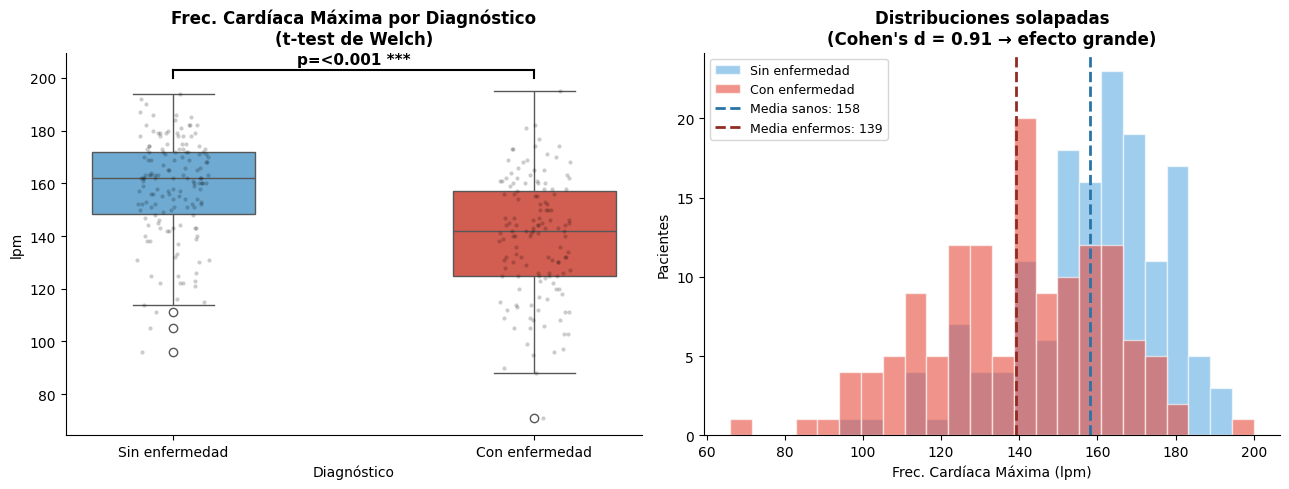

In [19]:
# Visualización del resultado del test t
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Boxplot con anotación del p-valor
sns.boxplot(data=df, x='target_label', y='thalach',
            palette=['#5DADE2', '#E74C3C'], width=0.45, ax=axes[0])
sns.stripplot(data=df, x='target_label', y='thalach',
              color='black', alpha=0.2, size=3, jitter=True, ax=axes[0])

# Añadir línea y p-valor manualmente
y_max = df['thalach'].max() + 8
axes[0].plot([0, 1], [y_max, y_max], 'k-', linewidth=1.5)
axes[0].plot([0, 0], [y_max - 3, y_max], 'k-', linewidth=1.5)
axes[0].plot([1, 1], [y_max - 3, y_max], 'k-', linewidth=1.5)
sig_text = f"p={'<0.001' if p_val < 0.001 else f'{p_val:.3f}'} {'***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'}"
axes[0].text(0.5, y_max + 1, sig_text, ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[0].set_title('Frec. Cardíaca Máxima por Diagnóstico\n(t-test de Welch)', fontweight='bold')
axes[0].set_xlabel('Diagnóstico')
axes[0].set_ylabel('lpm')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Histogramas superpuestos con medias
bins = np.linspace(df['thalach'].min() - 5, df['thalach'].max() + 5, 25)
axes[1].hist(sanos, bins=bins, alpha=0.6, color='#5DADE2', label='Sin enfermedad', edgecolor='white')
axes[1].hist(enfermos, bins=bins, alpha=0.6, color='#E74C3C', label='Con enfermedad', edgecolor='white')
axes[1].axvline(sanos.mean(), color='#2874A6', linestyle='--', linewidth=2, label=f'Media sanos: {sanos.mean():.0f}')
axes[1].axvline(enfermos.mean(), color='#922B21', linestyle='--', linewidth=2, label=f'Media enfermos: {enfermos.mean():.0f}')
axes[1].set_title(f'Distribuciones solapadas\n(Cohen\'s d = {d:.2f} → efecto grande)', fontweight='bold')
axes[1].set_xlabel('Frec. Cardíaca Máxima (lpm)')
axes[1].set_ylabel('Pacientes')
axes[1].legend(fontsize=9)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 3.4 Test de Mann-Whitney U — Alternativa no paramétrica al t-test

**Cuando usarlo:** Cuando los datos NO cumplen normalidad (o tienes dudas, o n < 30).
Compara **medianas** (en sentido amplio, rangos) en lugar de medias.

**H₀:** Las distribuciones de los dos grupos son iguales

**Ventaja:** No asume nada sobre la forma de la distribución.
**Desventaja:** Ligeramente menos potente que el t-test cuando la normalidad sí se cumple.

En la práctica clínica, con n > 30 en cada grupo, el t-test de Welch es bastante robusto
incluso con leve desviación de normalidad. Pero cuando hay dudas, Mann-Whitney es la opción segura.

In [20]:
# Aplicar Mann-Whitney U a la misma comparación
u_stat, p_valor_mw = mannwhitneyu(sanos, enfermos, alternative='two-sided')

print(f"\nMann-Whitney U — Frecuencia Cardíaca Máxima")
print(f"{'='*50}")
print(f"U-statistic = {u_stat:.2f}")
print(f"p-valor     = {p_valor_mw:.4f}")
print(f"\nMediana sanos:    {sanos.median():.1f} lpm")
print(f"Mediana enfermos: {enfermos.median():.1f} lpm")
print(f"\nConclusión: {'Diferencia significativa (p<0.05)' if p_valor_mw < 0.05 else 'No significativa'}")
print(f"\nNota: t-test p={p_val:.4f} vs Mann-Whitney p={p_valor_mw:.4f}")
print(f"Ambos tests coinciden → resultado robusto independientemente del método")


Mann-Whitney U — Frecuencia Cardíaca Máxima
U-statistic = 15272.50
p-valor     = 0.0000

Mediana sanos:    162.0 lpm
Mediana enfermos: 142.0 lpm

Conclusión: Diferencia significativa (p<0.05)

Nota: t-test p=0.0000 vs Mann-Whitney p=0.0000
Ambos tests coinciden → resultado robusto independientemente del método


## 3.5 ANOVA — Comparar medias entre más de dos grupos

**Cuando usarlo:** Variable continua, más de dos grupos, distribución normal.

**H₀:** Todas las medias son iguales (μ₁ = μ₂ = μ₃ = μ₄)

**Importante:** Un ANOVA significativo solo dice que AL MENOS UN grupo es diferente del resto.
No dice cuál. Para saber qué pares difieren, se necesitan tests post-hoc (Tukey HSD).

**Alternativa no paramétrica:** Test de Kruskal-Wallis

In [21]:
# Comparar frecuencia cardíaca máxima entre los 4 tipos de dolor torácico
grupos_cp = [df[df['cp'] == i]['thalach'].dropna() for i in sorted(df['cp'].dropna().unique())]
nombres_cp = ['Angina típica', 'Angina atípica', 'No anginoso', 'Asintomático']

# ANOVA
f_stat, p_anova = f_oneway(*grupos_cp)

# Kruskal-Wallis (no paramétrico)
kw_stat, p_kruskal = kruskal(*grupos_cp)

print("ANOVA — Frec. Cardíaca Máxima por Tipo de Dolor Torácico")
print("="*55)
for nombre, grupo in zip(nombres_cp, grupos_cp):
    print(f"  {nombre:20s}: media={grupo.mean():.1f}, sd={grupo.std():.1f}, n={len(grupo)}")
print(f"\nANOVA:          F={f_stat:.4f}, p={p_anova:.4f}")
print(f"Kruskal-Wallis: H={kw_stat:.4f}, p={p_kruskal:.4f}")
print(f"\nConclusión: {'Diferencia significativa entre grupos (p<0.05)' if p_anova < 0.05 else 'No significativa'}")

ANOVA — Frec. Cardíaca Máxima por Tipo de Dolor Torácico
  Angina típica       : media=156.0, sd=20.9, n=23
  Angina atípica      : media=160.9, sd=18.2, n=47
  No anginoso         : media=155.7, sd=19.2, n=81
  Asintomático        : media=140.1, sd=23.4, n=136

ANOVA:          F=16.3262, p=0.0000
Kruskal-Wallis: H=43.7891, p=0.0000

Conclusión: Diferencia significativa entre grupos (p<0.05)


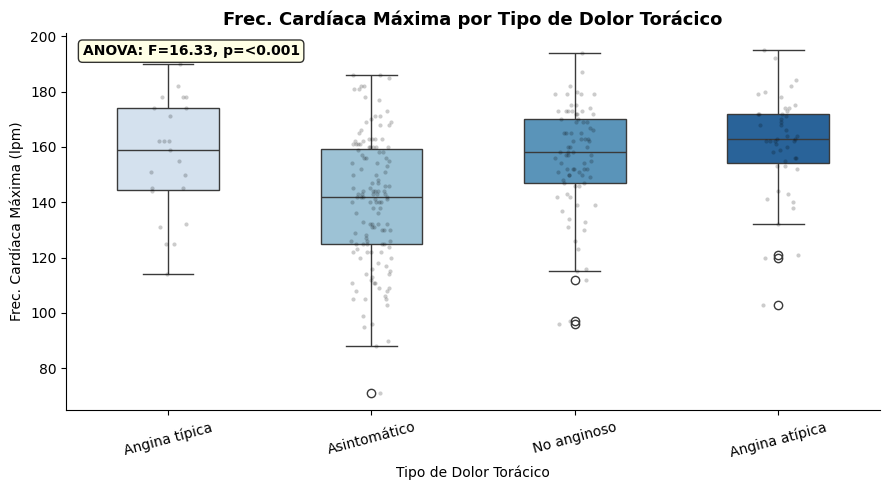

In [22]:
# Visualización ANOVA
fig, ax = plt.subplots(figsize=(9, 5))

df_cp = df[df['cp'].notna()].copy()
df_cp['cp_nombre'] = df_cp['cp'].map(dict(zip([1,2,3,4], nombres_cp)))

sns.boxplot(data=df_cp, x='cp_nombre', y='thalach',
            palette='Blues', width=0.5, ax=ax)
sns.stripplot(data=df_cp, x='cp_nombre', y='thalach',
              color='black', alpha=0.2, size=3, jitter=True, ax=ax)

p_text = f"ANOVA: F={f_stat:.2f}, p={'<0.001' if p_anova < 0.001 else f'{p_anova:.3f}'}"
ax.text(0.02, 0.97, p_text, transform=ax.transAxes,
        fontsize=10, va='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax.set_title('Frec. Cardíaca Máxima por Tipo de Dolor Torácico', fontsize=13, fontweight='bold')
ax.set_xlabel('Tipo de Dolor Torácico')
ax.set_ylabel('Frec. Cardíaca Máxima (lpm)')
ax.tick_params(axis='x', rotation=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 3.6 Correlación — Pearson vs Spearman

**Correlación de Pearson:** Mide la relación lineal entre dos variables continuas.
Asume que ambas variables son aproximadamente normales.
Rango: -1 (perfecta negativa) a +1 (perfecta positiva).

**Correlación de Spearman:** Versión no paramétrica. Mide la relación monótona
(no necesariamente lineal). Trabaja con rangos, no valores originales.
Más robusta ante outliers.

**Cuándo usar cada una:**
- Pearson si ambas variables son continuas y aproximadamente normales → relación lineal
- Spearman si hay outliers, distribuciones asimétricas o relaciones monótonas no lineales

In [23]:
# Correlación: edad vs frecuencia cardíaca máxima
datos_corr = df[['age', 'thalach', 'trestbps', 'chol', 'oldpeak', 'target']].dropna()

print("CORRELACIONES — Pearson y Spearman")
print("="*55)
print(f"\n{'Variable':<20} {'Pearson r':>10} {'p-Pearson':>10} {'Spearman ρ':>12} {'p-Spearman':>12}")
print("-"*65)

variable_objetivo = 'thalach'
otras_vars = ['age', 'trestbps', 'chol', 'oldpeak', 'target']

for var in otras_vars:
    r_p, p_p = pearsonr(datos_corr[variable_objetivo], datos_corr[var])
    r_s, p_s = spearmanr(datos_corr[variable_objetivo], datos_corr[var])
    sig_p = '*' * (1 if p_p < 0.05 else 0) + '*' * (1 if p_p < 0.01 else 0) + '*' * (1 if p_p < 0.001 else 0)
    print(f"{var:<20} {r_p:>10.3f} {p_p:>9.4f}{sig_p:<1}  {r_s:>10.3f} {p_s:>11.4f}")

print("\n* p<0.05   ** p<0.01   *** p<0.001")

CORRELACIONES — Pearson y Spearman

Variable              Pearson r  p-Pearson   Spearman ρ   p-Spearman
-----------------------------------------------------------------
age                      -0.385    0.0000***      -0.391      0.0000
trestbps                 -0.048    0.4176       -0.045      0.4468
chol                     -0.002    0.9668       -0.037      0.5350
oldpeak                  -0.347    0.0000***      -0.433      0.0000
target                   -0.415    0.0000***      -0.422      0.0000

* p<0.05   ** p<0.01   *** p<0.001


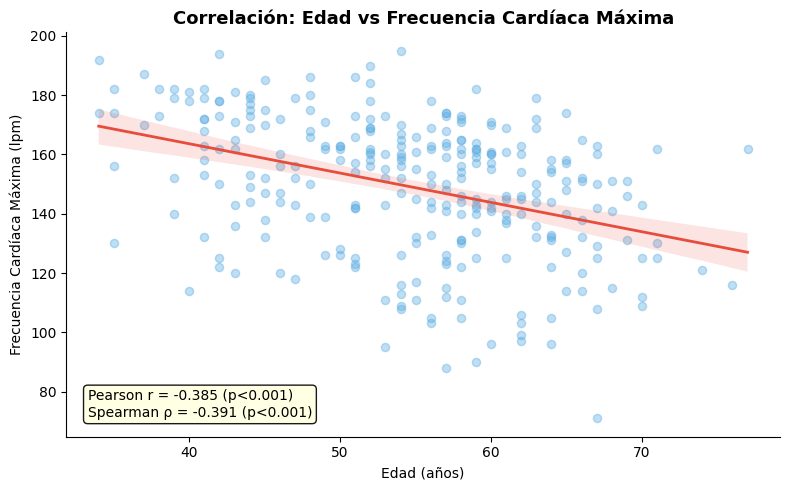

In [24]:
# Scatter de correlación más interesante: edad vs thalach
r_pearson, p_pearson = pearsonr(datos_corr['age'], datos_corr['thalach'])
r_spearman, p_spearman = spearmanr(datos_corr['age'], datos_corr['thalach'])

fig, ax = plt.subplots(figsize=(8, 5))
sns.regplot(data=datos_corr, x='age', y='thalach',
            scatter_kws={'alpha': 0.4, 'color': '#5DADE2', 's': 35},
            line_kws={'color': '#E74C3C', 'linewidth': 2}, ax=ax)

texto = (f"Pearson r = {r_pearson:.3f} (p{'<0.001' if p_pearson < 0.001 else f'={p_pearson:.3f}'})\n"
         f"Spearman ρ = {r_spearman:.3f} (p{'<0.001' if p_spearman < 0.001 else f'={p_spearman:.3f}'})")
ax.text(0.03, 0.05, texto, transform=ax.transAxes, fontsize=10,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

ax.set_title('Correlación: Edad vs Frecuencia Cardíaca Máxima', fontsize=13, fontweight='bold')
ax.set_xlabel('Edad (años)')
ax.set_ylabel('Frecuencia Cardíaca Máxima (lpm)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

---
# PARTE 4: Tests Estadísticos entre Variables Categóricas

Cuando nuestras variables son categóricas (sexo, tipo de dolor, presencia de enfermedad),
no podemos hablar de medias ni usar t-tests. Necesitamos tests basados en frecuencias.

## 4.1 Chi-cuadrado (χ²) — Independencia entre variables categóricas

**Cuando usarlo:** Dos variables categóricas, muestras independientes, frecuencias esperadas ≥ 5.

**H₀:** Las dos variables son independientes (no hay asociación entre ellas).

**Lógica del test:**
El test χ² compara las frecuencias observadas en cada celda de una tabla de contingencia
con las frecuencias que esperaríamos SI las dos variables fueran completamente independientes.
Si la diferencia entre lo observado y lo esperado es grande → p pequeño → rechazamos H₀.

**La tabla de contingencia** es el punto de partida imprescindible:
filas = una variable categórica, columnas = otra variable, celdas = frecuencias.

In [25]:
def test_chi2_completo(df, var1, var2, nombre_var1, nombre_var2):
    """
    Realiza un test chi-cuadrado completo con visualización.
    """
    # Tabla de contingencia
    tabla = pd.crosstab(df[var1], df[var2])

    # Test chi-cuadrado
    chi2, p_valor, dof, esperados = chi2_contingency(tabla)

    # Comprobar supuesto: frecuencias esperadas >= 5
    min_esperado = esperados.min()
    supuesto_ok = min_esperado >= 5

    # Tamaño del efecto: V de Cramér
    n = tabla.values.sum()
    k = min(tabla.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * k))

    if cramers_v < 0.1:
        efecto = "despreciable"
    elif cramers_v < 0.3:
        efecto = "pequeño"
    elif cramers_v < 0.5:
        efecto = "moderado"
    else:
        efecto = "grande"

    print(f"\n{'='*60}")
    print(f"CHI-CUADRADO: {nombre_var1} vs {nombre_var2}")
    print(f"{'='*60}")
    print(f"\nTabla de contingencia (frecuencias observadas):")
    print(tabla)
    print(f"\nFrecuencias esperadas (mínimo: {min_esperado:.1f})")
    print(f"{'✓ Supuesto cumplido' if supuesto_ok else '✗ AVISO: hay celdas con frecuencia esperada < 5 → considerar Fisher'}")
    print(f"\nResultado:")
    print(f"  χ² = {chi2:.4f}")
    print(f"  gl = {dof}")
    print(f"  p  = {p_valor:.4f}")
    print(f"  {'✓ Asociación estadísticamente significativa (p<0.05)' if p_valor < 0.05 else '✗ No hay evidencia de asociación (p≥0.05)'}")
    print(f"\nV de Cramér = {cramers_v:.3f} → efecto {efecto}")

    return tabla, chi2, p_valor, cramers_v

In [26]:
# Test 1: Sexo vs Diagnóstico de enfermedad coronaria
tabla_sexo, chi2_s, p_s, v_s = test_chi2_completo(
    df, 'sex', 'target',
    'Sexo', 'Diagnóstico'
)


CHI-CUADRADO: Sexo vs Diagnóstico

Tabla de contingencia (frecuencias observadas):
target   0    1
sex            
0       66   24
1       85  112

Frecuencias esperadas (mínimo: 42.6)
✓ Supuesto cumplido

Resultado:
  χ² = 21.3837
  gl = 1
  p  = 0.0000
  ✓ Asociación estadísticamente significativa (p<0.05)

V de Cramér = 0.273 → efecto pequeño


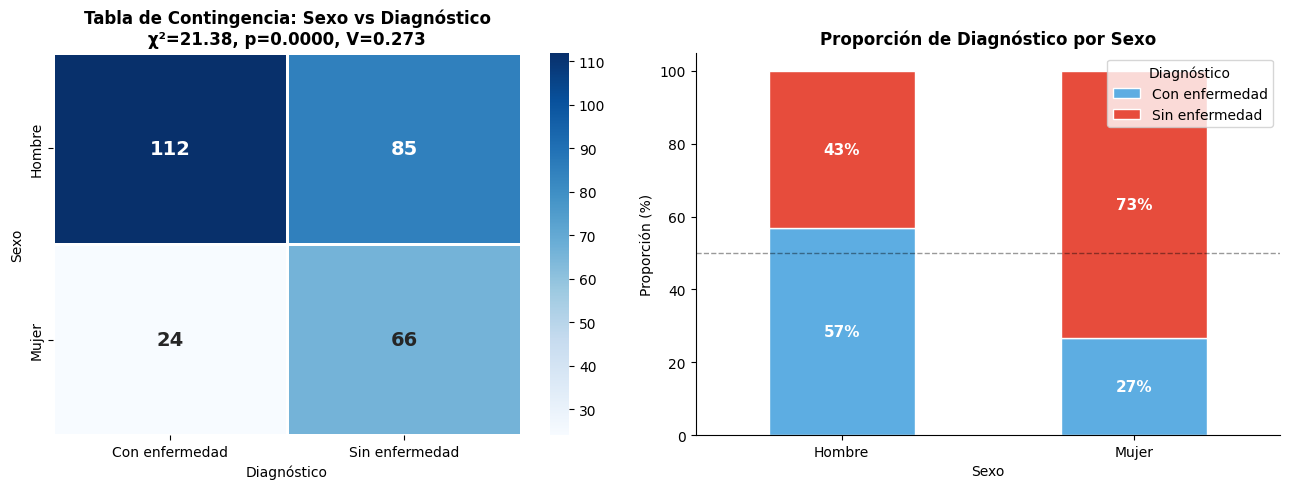

In [27]:
# Visualización de la tabla de contingencia
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Mapa de calor de la tabla de contingencia
tabla_display = pd.crosstab(df['sex_label'], df['target_label'])
sns.heatmap(tabla_display, annot=True, fmt='d', cmap='Blues',
            linewidths=1, linecolor='white',
            annot_kws={'fontsize': 14, 'fontweight': 'bold'}, ax=axes[0])
axes[0].set_title(f'Tabla de Contingencia: Sexo vs Diagnóstico\nχ²={chi2_s:.2f}, p={p_s:.4f}, V={v_s:.3f}',
                  fontweight='bold')
axes[0].set_xlabel('Diagnóstico')
axes[0].set_ylabel('Sexo')

# Barras apiladas al 100%
prop_tabla = tabla_display.div(tabla_display.sum(axis=1), axis=0) * 100
prop_tabla.plot(kind='bar', stacked=True, ax=axes[1],
                color=['#5DADE2', '#E74C3C'], edgecolor='white', rot=0)
axes[1].axhline(50, color='black', linestyle='--', linewidth=1, alpha=0.4)
axes[1].set_title('Proporción de Diagnóstico por Sexo', fontweight='bold')
axes[1].set_xlabel('Sexo')
axes[1].set_ylabel('Proporción (%)')
axes[1].legend(title='Diagnóstico')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Anotar proporciones en las barras
for i, (idx, row) in enumerate(prop_tabla.iterrows()):
    cumulative = 0
    for j, val in enumerate(row):
        axes[1].text(i, cumulative + val/2, f'{val:.0f}%',
                     ha='center', va='center', fontweight='bold', fontsize=11, color='white')
        cumulative += val

plt.tight_layout()
plt.show()

In [28]:
# Test 2: Tipo de dolor vs Diagnóstico (más de 2 categorías)
tabla_cp, chi2_cp, p_cp, v_cp = test_chi2_completo(
    df, 'cp', 'target',
    'Tipo de Dolor', 'Diagnóstico'
)


CHI-CUADRADO: Tipo de Dolor vs Diagnóstico

Tabla de contingencia (frecuencias observadas):
target   0    1
cp             
1       16    7
2       38    9
3       64   17
4       33  103

Frecuencias esperadas (mínimo: 10.9)
✓ Supuesto cumplido

Resultado:
  χ² = 84.1623
  gl = 3
  p  = 0.0000
  ✓ Asociación estadísticamente significativa (p<0.05)

V de Cramér = 0.542 → efecto grande


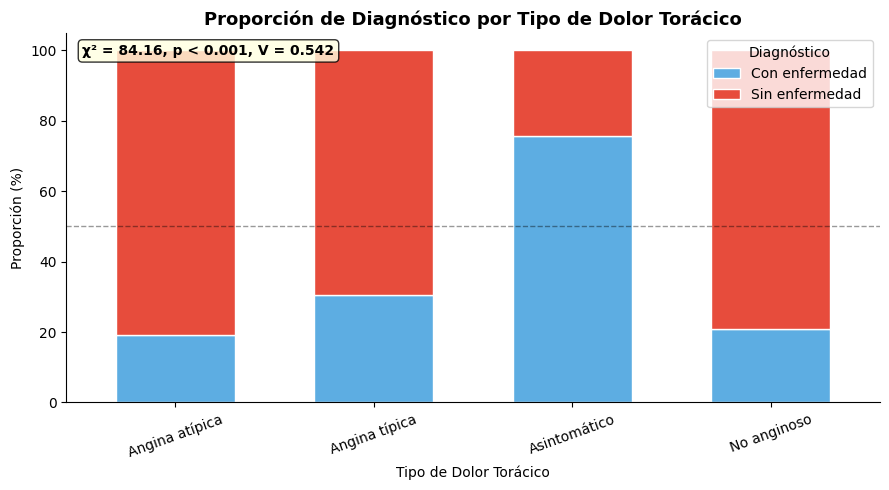

In [29]:
# Visualización del segundo test
fig, ax = plt.subplots(figsize=(9, 5))

prop_cp = pd.crosstab(df['cp_label'], df['target_label'], normalize='index') * 100
prop_cp.plot(kind='bar', stacked=True, ax=ax,
             color=['#5DADE2', '#E74C3C'], edgecolor='white', rot=20, width=0.6)

ax.axhline(50, color='black', linestyle='--', linewidth=1, alpha=0.4)
p_texto = f"χ² = {chi2_cp:.2f}, p {'< 0.001' if p_cp < 0.001 else f'= {p_cp:.3f}'}, V = {v_cp:.3f}"
ax.text(0.02, 0.97, p_texto, transform=ax.transAxes, fontsize=10, va='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax.set_title('Proporción de Diagnóstico por Tipo de Dolor Torácico', fontsize=13, fontweight='bold')
ax.set_xlabel('Tipo de Dolor Torácico')
ax.set_ylabel('Proporción (%)')
ax.legend(title='Diagnóstico')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 4.2 Test exacto de Fisher — Para tablas 2×2 con frecuencias bajas

**Cuando usarlo:** Tabla 2×2, alguna celda con frecuencia esperada < 5.
En estudios clínicos con pocos pacientes o eventos raros, es muy frecuente.

**H₀:** No hay asociación entre las dos variables (odds ratio = 1).

**Ventaja sobre chi-cuadrado:** No requiere el supuesto de frecuencias esperadas ≥ 5.
Es exacto (no es una aproximación asintótica).

**Limitación:** Solo funciona con tablas 2×2. Para tablas mayores con frecuencias bajas,
existe el test exacto de Freeman-Halton (menos común).

In [30]:
# Ejemplo: Angina en reposo (fbs>120 mg/dl) vs diagnóstico en pacientes > 65 años
# Subgrupo pequeño donde Fisher puede ser necesario
df_mayores = df[df['age'] >= 65].copy()
print(f"Pacientes ≥ 65 años: n={len(df_mayores)}")

tabla_fisher = pd.crosstab(df_mayores['fbs'], df_mayores['target'])
print("\nTabla de contingencia (fbs vs target en >65 años):")
print(tabla_fisher)

# Comprobar si chi2 es apropiado
_, _, _, esperados = chi2_contingency(tabla_fisher)
print(f"\nFrecuencias esperadas mínimas: {esperados.min():.1f}")

# Aplicar Fisher si hay celdas con frecuencia esperada < 5
if esperados.min() < 5:
    print("→ Frecuencias esperadas < 5: usar Test de Fisher")
    # Fisher requiere tabla 2x2
    if tabla_fisher.shape == (2, 2):
        odds_ratio, p_fisher = fisher_exact(tabla_fisher)
        print(f"\nTest Exacto de Fisher:")
        print(f"  Odds Ratio = {odds_ratio:.3f}")
        print(f"  p-valor    = {p_fisher:.4f}")
        print(f"  {'✓ Asociación significativa' if p_fisher < 0.05 else '✗ No significativa'}")
        interpretacion_or = "mayor" if odds_ratio > 1 else "menor"
        print(f"\nInterpretación: El OR={odds_ratio:.2f} indica que pacientes con glucemia en ayunas")
        print(f"  >120 mg/dL tienen {odds_ratio:.1f}x {'más' if odds_ratio > 1 else 'menos'} odds de")
        print(f"  tener enfermedad coronaria (en este subgrupo de mayores de 65).")
else:
    chi2_f, p_chi2_f, dof_f, _ = chi2_contingency(tabla_fisher)
    print(f"→ Chi-cuadrado apropiado: χ²={chi2_f:.3f}, p={p_chi2_f:.4f}")

Pacientes ≥ 65 años: n=39

Tabla de contingencia (fbs vs target en >65 años):
target   0   1
fbs           
0       17  15
1        3   4

Frecuencias esperadas mínimas: 3.4
→ Frecuencias esperadas < 5: usar Test de Fisher

Test Exacto de Fisher:
  Odds Ratio = 1.511
  p-valor    = 0.6948
  ✗ No significativa

Interpretación: El OR=1.51 indica que pacientes con glucemia en ayunas
  >120 mg/dL tienen 1.5x más odds de
  tener enfermedad coronaria (en este subgrupo de mayores de 65).


---
# PARTE 5: Guía de Selección de Test Estadístico

El error más frecuente es usar el test incorrecto. Esta guía te ayudará a elegir bien.

In [31]:
# Tabla resumen visual de selección de tests

print("""
╔══════════════════════════════════════════════════════════════════════╗
║          GUÍA DE SELECCIÓN DE TEST ESTADÍSTICO                       ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  COMPARAR UNA VARIABLE CONTINUA ENTRE GRUPOS                         ║
║  ┌─────────────────┬──────────────────────────────────────────┐      ║
║  │ 2 grupos indep. │ Normal? → t-test Welch                   │      ║
║  │                 │ No normal/outliers? → Mann-Whitney U     │      ║
║  ├─────────────────┼──────────────────────────────────────────┤      ║
║  │ > 2 grupos      │ Normal? → ANOVA + Tukey post-hoc         │      ║
║  │                 │ No normal? → Kruskal-Wallis              │      ║
║  └─────────────────┴──────────────────────────────────────────┘      ║
║                                                                      ║
║  RELACIÓN ENTRE DOS VARIABLES CONTINUAS                              ║
║  ┌─────────────────┬──────────────────────────────────────────┐      ║
║  │ Relación lineal │ Normal? → Pearson r                      │      ║
║  │ / monótona      │ No normal/outliers? → Spearman ρ         │      ║
║  └─────────────────┴──────────────────────────────────────────┘      ║
║                                                                      ║
║  ASOCIACIÓN ENTRE DOS VARIABLES CATEGÓRICAS                          ║
║  ┌─────────────────┬──────────────────────────────────────────┐      ║
║  │ Frec. esp. ≥ 5  │ Chi-cuadrado (cualquier tamaño tabla)    │      ║
║  ├─────────────────┼──────────────────────────────────────────┤      ║
║  │ Frec. esp. < 5  │ Tabla 2×2 → Fisher exacto               │      ║
║  │                 │ Tabla mayor → Freeman-Halton             │      ║
║  └─────────────────┴──────────────────────────────────────────┘      ║
║                                                                      ║
║  COMPROBAR NORMALIDAD                                                ║
║  → Shapiro-Wilk (n < 50) + QQ-plot siempre                          ║
║  → Con n grande: confiar más en el QQ-plot que en el p-valor         ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║          GUÍA DE SELECCIÓN DE TEST ESTADÍSTICO                       ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  COMPARAR UNA VARIABLE CONTINUA ENTRE GRUPOS                         ║
║  ┌─────────────────┬──────────────────────────────────────────┐      ║
║  │ 2 grupos indep. │ Normal? → t-test Welch                   │      ║
║  │                 │ No normal/outliers? → Mann-Whitney U     │      ║
║  ├─────────────────┼──────────────────────────────────────────┤      ║
║  │ > 2 grupos      │ Normal? → ANOVA + Tukey post-hoc         │      ║
║  │                 │ No normal? → Kruskal-Wallis              │      ║
║  └─────────────────┴──────────────────────────────────────────┘      ║
║                                                                      ║
║  RELACIÓN ENTRE DOS VARIABLES CONTINUAS         

---
# PARTE 6: Integrador — Perfil Estadístico Completo

Vamos a construir un análisis estadístico completo comparando pacientes con y sin
enfermedad coronaria. Esto replica exactamente el tipo de tabla que aparece en la
sección "Características basales" de los artículos clínicos (la famosa "Tabla 1").

In [34]:
def tabla_1_clinica(df, grupo_var, grupo_labels, vars_continuas, vars_categoricas):
    """
    Genera la 'Tabla 1' clínica: estadísticos y tests para todas las variables de interés.
    """
    grupo0 = df[df[grupo_var] == 0]
    grupo1 = df[df[grupo_var] == 1]
    n0, n1 = len(grupo0), len(grupo1)

    print(f"\n{'='*75}")
    print(f"TABLA 1 — CARACTERÍSTICAS BASALES POR GRUPO DIAGNÓSTICO")
    print(f"{'='*75}")
    print(f"\n{'':30s} {grupo_labels[0]:>20s}   {grupo_labels[1]:>20s}   {'p-valor':>10s}")
    print(f"{'':30s} {'(n='+str(n0)+')':>20s}   {'(n='+str(n1)+')':>20s}")
    print(f"{'-'*75}")

    print(f"\n  VARIABLES CONTINUAS (media ± DE)")
    for var, label in vars_continuas:
        d0 = grupo0[var].dropna()
        d1 = grupo1[var].dropna()
        _, p = ttest_ind(d0, d1, equal_var=False)
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        print(f"  {label:28s} {d0.mean():8.1f} ± {d0.std():.1f}     {d1.mean():8.1f} ± {d1.std():.1f}     {p:.4f} {sig}")

    print(f"\n  VARIABLES CATEGÓRICAS (n, %)")
    for var, label, cats in vars_categoricas:
        print(f"\n  {label}:")
        tabla_ct = pd.crosstab(df[var], df[grupo_var])
        _, p_chi, _, _ = chi2_contingency(tabla_ct)
        sig = '***' if p_chi < 0.001 else '**' if p_chi < 0.01 else '*' if p_chi < 0.05 else 'ns'
        for cat_val, cat_nombre in cats:
            if cat_val in tabla_ct.index:
                n_g0 = tabla_ct.loc[cat_val, 0] if 0 in tabla_ct.columns else 0
                n_g1 = tabla_ct.loc[cat_val, 1] if 1 in tabla_ct.columns else 0
                pct0 = n_g0 / n0 * 100
                pct1 = n_g1 / n1 * 100
                chi2_str = f"χ²: p={p_chi:.4f} {sig}" if cat_val == cats[0][0] else ''
                print(f"    {cat_nombre:26s} {n_g0:4d} ({pct0:4.1f}%)           {n_g1:4d} ({pct1:4.1f}%)    {chi2_str}")

    print(f"\n{'='*75}")
    print(f"*** p<0.001  ** p<0.01  * p<0.05  ns = no significativo")

In [35]:
vars_cont = [
    ('age',     'Edad (años)'),
    ('trestbps','Presión arterial (mmHg)'),
    ('chol',    'Colesterol (mg/dL)'),
    ('thalach', 'Frec. cardíaca máx. (lpm)'),
    ('oldpeak', 'Depresión ST (mm)'),
]

vars_cat = [
    ('sex', 'Sexo', [(0, 'Mujer'), (1, 'Hombre')]),
    ('fbs', 'Glucemia ayunas >120 mg/dL', [(0, 'No'), (1, 'Sí')]),
    ('exang', 'Angina inducida por ejercicio', [(0, 'No'), (1, 'Sí')]),
    ('cp', 'Tipo de dolor torácico',
     [(1, 'Angina típica'), (2, 'Angina atípica'), (3, 'No anginoso'), (4, 'Asintomático')]),
]

tabla_1_clinica(df, 'target',
                ['Sin enfermedad', 'Con enfermedad'],
                vars_cont, vars_cat)


TABLA 1 — CARACTERÍSTICAS BASALES POR GRUPO DIAGNÓSTICO

                                     Sin enfermedad         Con enfermedad      p-valor
                                            (n=151)                (n=136)
---------------------------------------------------------------------------

  VARIABLES CONTINUAS (media ± DE)
  Edad (años)                      53.0 ± 9.4         56.5 ± 7.9     0.0007 ***
  Presión arterial (mmHg)         129.6 ± 16.4        134.2 ± 18.5     0.0282 *
  Colesterol (mg/dL)              242.7 ± 53.9        250.5 ± 48.0     0.1942 ns
  Frec. cardíaca máx. (lpm)       158.2 ± 19.1        139.1 ± 22.8     0.0000 ***
  Depresión ST (mm)                 0.6 ± 0.8          1.5 ± 1.3     0.0000 ***

  VARIABLES CATEGÓRICAS (n, %)

  Sexo:
    Mujer                        66 (43.7%)             24 (17.6%)    χ²: p=0.0000 ***
    Hombre                       85 (56.3%)            112 (82.4%)    

  Glucemia ayunas >120 mg/dL:
    No                          12

Esta es exactamente la "Tabla 1" que verías en la sección de resultados de cualquier
artículo clínico. Los asteriscos indican significación estadística, pero siempre
hay que mirar también la magnitud de las diferencias (¿es clínicamente relevante
que la media de colesterol difiera en 5 mg/dL aunque p<0.05?).

---
# EJERCICIOS

### Ejercicio 1 — Visualización básica

Usando el dataset cargado:

1. Crea un histograma de la variable `trestbps` (presión arterial en reposo)
   separado por diagnóstico (hue='target_label'). Añade KDE y título descriptivo.
2. Crea un boxplot de `oldpeak` (depresión del segmento ST) por tipo de dolor torácico.
   Superpón los puntos individuales con `stripplot`.
3. ¿Qué observas clínicamente en cada gráfico?

In [36]:
# Respuesta ejercicio 1

### Ejercicio 2 — Tests entre variables continuas

Queremos saber si la presión arterial en reposo (`trestbps`) es diferente entre
hombres y mujeres en este dataset.

1. Visualiza la distribución con un boxplot y un histograma por grupos
2. Comprueba la normalidad de cada grupo con Shapiro-Wilk + QQ-plot
3. Elige el test apropiado (t-test de Welch o Mann-Whitney) y justifica tu elección
4. Ejecuta el test e interpreta el resultado: ¿existe diferencia significativa?
   ¿cuál es el tamaño del efecto? ¿es clínicamente relevante?

In [37]:
# Respuesta ejercicio 2

### Ejercicio 3 — Chi-cuadrado

Analiza la asociación entre la presencia de angina inducida por ejercicio (`exang`)
y el diagnóstico de enfermedad coronaria (`target`).

1. Construye la tabla de contingencia con `pd.crosstab()`
2. Verifica el supuesto de frecuencias esperadas ≥ 5
3. Aplica el test chi-cuadrado (o Fisher si es necesario)
4. Calcula la V de Cramér como medida de tamaño del efecto
5. Interpreta el resultado clínicamente: ¿tiene sentido fisiológico la asociación?

In [38]:
# Respuesta ejercicio 3

### Ejercicio 4 — ANOVA + visualización

Compara los niveles de colesterol (`chol`) entre los cuatro tipos de dolor torácico.

1. Realiza un boxplot con los cuatro grupos y stripplot superpuesto
2. Comprueba si el ANOVA es apropiado (normalidad en cada grupo)
3. Aplica ANOVA (o Kruskal-Wallis si procede)
4. Si el test global es significativo, identifica visualmente qué grupos difieren más
5. Interpreta: ¿hay un patrón clínico coherente en los niveles de colesterol según el tipo de dolor?

In [39]:
# Respuesta ejercicio 4

### Ejercicio Integrador — Exploración de una nueva variable

La variable `thal` representa el resultado de la gammagrafía de perfusión cardíaca:
- 3 = Normal
- 6 = Defecto fijo (infarto antiguo)
- 7 = Defecto reversible (isquemia activa)

1. Crea un gráfico de barras apiladas al 100% de `thal` vs `target`
2. Aplica el test chi-cuadrado para evaluar la asociación
3. Compara la frecuencia cardíaca máxima (`thalach`) entre los tres grupos de `thal`
   con el test apropiado
4. Genera el heatmap de correlación incluyendo `thal` junto a las variables continuas
5. Resume en 3-4 frases los hallazgos más relevantes desde el punto de vista clínico

In [40]:
# Respuesta ejercicio integrador